# N-electrodes

## Data preparation

### Importing modules

In [1]:
import random
import kwant
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import logging
import math
from tqdm import tqdm
import shutil
import tarfile
from matplotlib import cm

c:\Users\julie\anaconda3\envs\c3mp\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
c:\Users\julie\anaconda3\envs\c3mp\lib\site-packages\kwant\solvers\default.py:16: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  warnings.warn("MUMPS is not available, "


### Defining `make_system` function

This function plays a crucial role since it is how the system is defined.

In [2]:
def make_system(
    scatter_width: int,
    scatter_length: int,
    leads_orientation: list,
    leads_up_shift: list,
    scatter_up_shift: int = 0,
    verbose: bool = False,
) -> tuple:
    """
    Creates a kwant system, made of a simple rectangular scattering region and N leads.
    
    Parameters
    ----------
    * scatter_width (int): width of the scattering region, in layers.
    * scatter_length (int): length of the scattering region, in number of 'honeycomb' cells (ie. 2N layers).
    * leads_orientation (list): list of the orientations of the leads. Each element of the list must be either 'l' or 'r'.
    * leads_up_shift (list): list of the up shifts of the leads, in layers. Each element of the list must be an integer. Positive values will shift the region up, negative values will shift it down.
    * scatter_up_shift (int): up shift of the scattering region, in layers. Positive values will shift the region up, negative values will shift it down.
    * verbose (bool): whether to print the system parameters or not.
    
    Returns
    -------
    * (kwant.builder.Builder): the scattering region.
    * (list): the leads.
    """

    if verbose: print("Building a system with the following parameters:")
    if verbose: print(f"Scatter region: {scatter_width:>2} layers wide & {scatter_length:>2} 'honeycomb' long (ie. {4*scatter_length:>2} layers long)")

    # Defining constants
    # ------------------

    SIN_60 = math.sin(math.pi / 3)
    GRAPHENE = kwant.lattice.general(
        [(0, math.sqrt(3)), (-3/2, -math.sqrt(3)/2)], # base vectors
        [(0, 0), (1/2,math.sqrt(3)/2)], # initial atoms (in cartesian coordinates), one for each atom in the unit cell
        norbs = 1, # number of orbitals per site
    )
    POT = 0.0
    T = 1
    SCATTER_LENGTH = 3 * scatter_length
    LEAD_LENGTH = 3
    LEAD_WIDTH = 2
    SMALL = 1e-3

    # Defining the scattering region
    # ------------------------------

    def scatter_rect(pos):
        x, y = pos
        is_inside_rectangle = ((0 < x + SMALL < SCATTER_LENGTH) and (scatter_up_shift * SIN_60 < y + SMALL < scatter_width * SIN_60 + scatter_up_shift * SIN_60))

        return is_inside_rectangle
    sys = kwant.Builder()
    sys[GRAPHENE.shape(scatter_rect, start=(0 if scatter_up_shift % 2 == 0 else 1/2, 0 * scatter_up_shift * SIN_60))] = POT
    sys[GRAPHENE.neighbors()] = -T

    # Defining the leads
    # ------------------

    leads = []

    for orientation, up_shift in zip(leads_orientation, leads_up_shift):

        if verbose: print(
            "Lead will be inside [{};{}]x[{};{}]" \
            .format(0, LEAD_LENGTH, up_shift * SIN_60, LEAD_WIDTH * SIN_60 + up_shift * SIN_60)
        )
        
        def lead_rect_left(pos):
            x, y = pos
            is_inside_rectangle = ((0 < x + SMALL < LEAD_LENGTH) and (up_shift * SIN_60 < y + SMALL < LEAD_WIDTH * SIN_60 + up_shift * SIN_60))
            return is_inside_rectangle

        def lead_rect_right(pos):
            x, y = pos
            is_inside_rectangle = ((0 < x + SMALL < LEAD_LENGTH) and (up_shift * SIN_60 < y + SMALL < LEAD_WIDTH * SIN_60 + up_shift * SIN_60))
            return is_inside_rectangle
        
        if orientation == 'l':
            sym = kwant.TranslationalSymmetry((LEAD_LENGTH, 0))
            lead = kwant.Builder(sym)
            lead[GRAPHENE.shape(lead_rect_left, start=(0 if up_shift % 2 == 0 else 1/2, up_shift * SIN_60))] = POT
            lead[GRAPHENE.neighbors()] = -T
            lead = lead.reversed()
        elif orientation == 'r':
            sym = kwant.TranslationalSymmetry((LEAD_LENGTH, 0))
            lead = kwant.Builder(sym)
            lead[GRAPHENE.shape(lead_rect_right, start=(0 if up_shift % 2 == 0 else 1/2, up_shift * SIN_60))] = POT
            lead[GRAPHENE.neighbors()] = -T
        else:
            raise ValueError(f"Unknown lead orientation: {orientation}")
        leads.append(lead)

    return sys, leads

### Defining other functions

In [123]:
def compute_conductance(fsyst, energies: list, t: float, from_lead_index, to_lead_index) -> list:
    """Computes the conductance of a scattering region for a given energy."""
    conductance = []
    SMALL = 1e-10
    for energy in energies:
        smatrix = kwant.smatrix(fsyst, energy * t + SMALL)
        conductance.append(smatrix.transmission(from_lead_index, to_lead_index))
    return conductance

def compute_current(fsyst, incomming_lead_index, energy: float, t: float):
    """Computes the current in a scattering region for a given energy."""
    SMALL = 1e-10
    wave_functions = kwant.wave_function(fsyst, energy * t + SMALL)(incomming_lead_index)
    hoppings_iterator = kwant.plotter.sys_leads_hoppings(sys=fsyst, num_lead_cells=0)
    hoppings_coordinates = kwant.plotter.sys_leads_hopping_pos(fsyst, hop_lead_nr=hoppings_iterator[0])
    channels = len(wave_functions)
    num_arrows = len(hoppings_coordinates[0])
    total_current = [0] * 2 * num_arrows
    for wave_function in wave_functions:
        current_operator = kwant.operator.Current(fsyst)
        current = current_operator(wave_function)
        total_current = list(map(np.add, current, total_current))
    current_intensity = list(total_current)[:num_arrows]
    return current_intensity, channels, hoppings_coordinates, None, num_arrows

def map_range(x, x1, x2, y1, y2):
    return (x - x1) * (y2 - y1) / (x2 - x1) + y1

## Studying

In the following, we will mainly focus on a simple aromatic molecule: naphtalene.

### Defining a system

We start by connecting random leads (between 2 and 6 of them).

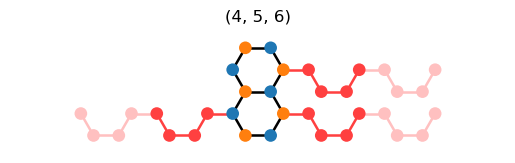

In [218]:
# Defining possible leads parameters for naphtalene
LEAD_ORIENTATIONS = ['l', 'r', 'l', 'r', 'l', 'r']
LEAD_UP_SHIFTS = [5, 5, 3, 3, 1, 1]

# Chosing some random leads parameters
number_of_leads_to_use = np.random.randint(2, 6)
indices = sorted(np.random.choice(
    a=np.arange(6),
    size=number_of_leads_to_use,
    replace=False),
)
indices_str = [str(i+1) for i in indices]

# Building the system
scatter, leads = make_system(
    scatter_width=5,
    scatter_length=1,
    scatter_up_shift=1,
    leads_orientation=[x for i, x in enumerate(LEAD_ORIENTATIONS) if i in indices],
    leads_up_shift=[x for i, x in enumerate(LEAD_UP_SHIFTS) if i in indices],
    verbose=False,
)

# Attaching the leads
for lead in leads:
    scatter.attach_lead(lead)

# Finalizing the system
fsyst = scatter.finalized()

# Plotting the system
fig, ax = plt.subplots()
kwant.plot(fsyst, ax=ax)
ax.set(
    aspect='equal',
    xmargin=0.2,
    ymargin=0.2,
    title="("+", ".join(indices_str)+")",
)
ax.axis('off')
plt.show()

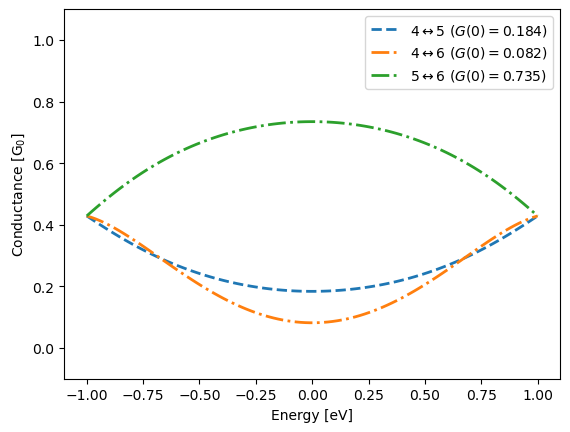

In [224]:
conductances = np.zeros((number_of_leads_to_use, number_of_leads_to_use))
linestyles = ['-', '--', '-.', ':']
for i in range(number_of_leads_to_use):
    for j in range(number_of_leads_to_use):
        if i >= j: continue
        energies = np.linspace(-1, 1, 100)
        conductance = np.array(compute_conductance(fsyst, energies, 1, i, j))
        conductances[i, j] = conductance[len(energies)//2]
        conductances[j, i] = conductance[len(energies)//2]
        index = 4 * i + j
        plt.plot(
            energies,
            conductance,
            linestyle=linestyles[index % 4],
            linewidth=map_range(index, 0, 15, 2, 2),
            label=f"${indices_str[i]}\\leftrightarrow{indices_str[j]}$ ($G(0)={conductance[len(energies)//2]:.3f}$)",
        )
        # plt.axhline(
        #     conductance[len(energies)//2],
        #     color='black',
        #     linestyle=linestyles[index % 4],
        #     label=f"{conductance[len(energies)//2]:.3f}",
        # )
plt.ylim(-.1, 1.1)
plt.xlabel("Energy [eV]")
plt.ylabel("Conductance [G$_0$]")
plt.legend()
plt.show()

In [220]:
def draw_current(
        fsyst,
        incomming_lead_index,
        energy: float = 0.5,
        t: float = 1/2.75,
        include_text: bool = True,
        ax: plt.Axes = None,
    ):

    current_intensity, num_channels, hoppings_coordinates, _, num_arrows = compute_current(fsyst, incomming_lead_index, energy, t)

    normalized_current_intensity = map_range(np.abs(current_intensity), min(np.abs(current_intensity)), max(np.abs(current_intensity)), 0, 1)
    normalized_current_intensity *= np.sign(current_intensity)

    min_transmission_drawn = -0.1
    dim = 30

    if ax is None:
        fig, ax = plt.subplots()

    for j in range(num_arrows):
        if np.abs(normalized_current_intensity[j]) <= min_transmission_drawn: continue
        normvalue = (np.abs(normalized_current_intensity[j]))
        normvalue_min = (min(abs(normalized_current_intensity)))
        x1 = hoppings_coordinates[0][j][0]
        y1 = hoppings_coordinates[0][j][1]
        x2 = hoppings_coordinates[1][j][0]
        y2 = hoppings_coordinates[1][j][1]
        if normalized_current_intensity[j]<0:
            x1, x2 = x2, x1
            y1, y2 = y2, y1
        thickness = map_range(normvalue, normvalue_min, 1, 0, 150) / dim
        ax.annotate(
            "",
            xy=(x1, y1),
            xytext=(x2, y2),
            arrowprops=dict(
                color=plt.cm.magma(map_range(normvalue, normvalue_min, 1, 1, 0)),
                headlength=map_range(normvalue, normvalue_min, 1, 200, 100) / dim,
                headwidth=map_range(normvalue, normvalue_min, 1, 100, 350) / dim,
                width=thickness, # switch to 40 if the arrows are too thick
            )
        )
        if include_text:
            x = (x1 + x2) / 2
            y = (y1 + y2) / 2
            angle = math.atan2(y2 - y1, x2 - x1)
            angle = (angle * 180 / math.pi + 90) % 180 - 90
            plt.text(
                x=x - (0.2 + thickness / 50) * math.sin(angle * math.pi / 180),
                y=y + (0.2 + thickness / 50) * math.cos(angle * math.pi / 180),
                s=f"{abs(current_intensity[j]):.0%}",
                color="black",
                horizontalalignment="center",
                verticalalignment="center",
                rotation=angle,
            )

    kwant.plot(
        fsyst,
        num_lead_cells=2,
        site_size=0,
        hop_color="w",
        lead_site_size=0,
        lead_color="gray",
        ax=ax,
    )
    ax.set(
        aspect='equal',
        xmargin=0.2,
        ymargin=0.2,
        title="("+", ".join(indices_str)+")",
    )
    ax.axis('off')

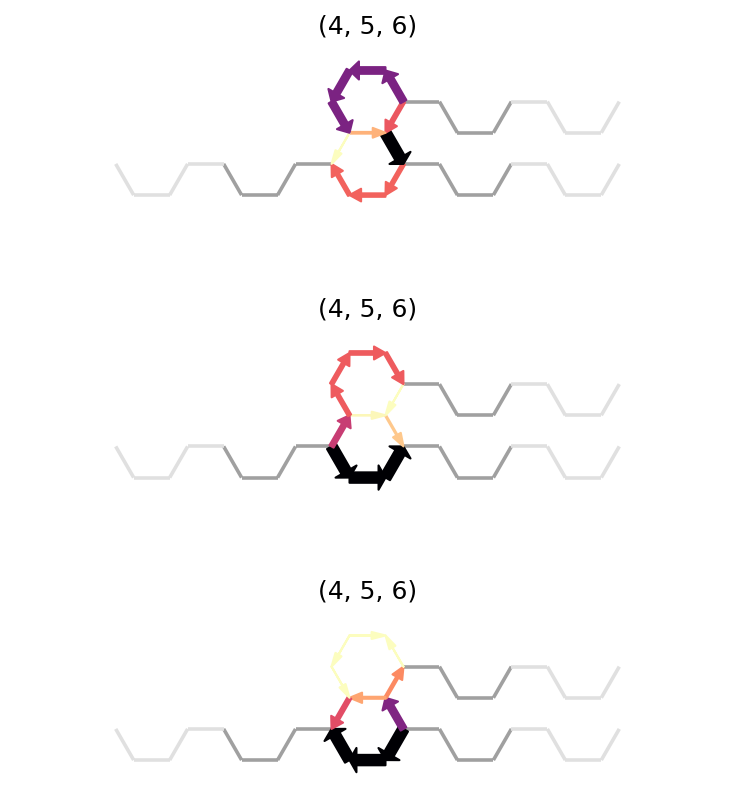

In [223]:
fig, axes = plt.subplots(nrows=number_of_leads_to_use, ncols=1, figsize=(5, 2 * number_of_leads_to_use), dpi=150)

for i in range(number_of_leads_to_use):
    draw_current(fsyst=fsyst, incomming_lead_index=i, include_text=False, ax=axes[i])

fig.tight_layout()
plt.show()